# Emotion Classification Mini Project
By Ashley Chacon

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This Google Collab is inspired by the CNN TensorFlow tutorial It creates an image classifier using a `tf.keras.Sequential` model, and loads data using `tf.keras.utils.image_dataset_from_directory`.

This following is conducted in this project:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process



## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
import seaborn as sns
import plotly.express as px

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

## Download and explore the dataset

Download the emotion detection dataset from Kaggle.com: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer

After download, you will have to upload the dataset to this Google Collab. Select the files tab on the lefthand tool bar, and upload manually from your computer downloads.

After downloading, you should now have a copy of the dataset available. There are 28709 training images and 7178 testing images:

In [2]:
import pathlib
import zipfile


with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall()


In [3]:
data_dir_train = "./train"
data_dir_test = "./test"

data_dir_train = pathlib.Path(data_dir_train)
data_dir_test = pathlib.Path(data_dir_test)


train_image_count = len(list(data_dir_train.glob('*/*.png')))
print("Number of training images:", train_image_count)

test_image_count = len(list(data_dir_test.glob('*/*.png')))
print("Number of testing images:", test_image_count)


Number of training images: 28709
Number of testing images: 7178


To test that the data has been read, display images from the dataset folder:

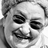

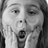

In [4]:
happy_images = list(data_dir_train.glob('happy/*'))
display(PIL.Image.open(str(happy_images[0])))

surprised_images = list(data_dir_train.glob('surprised/*'))
display(PIL.Image.open(str(surprised_images[0])))

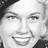

In [5]:
display(PIL.Image.open(str(happy_images[73])))

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code.

## Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 48
img_width = 48

Split your testing and training data to their designated space. 

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7178 files belonging to 7 classes.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [9]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


## Visualize the data

Here are the first nine images from the training dataset:

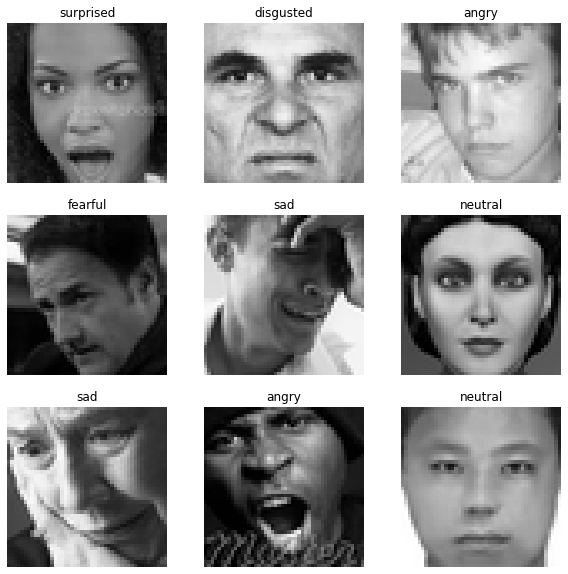

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 48, 48, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 48, 48, 3)`. This is a batch of 32 images of shape `48x48x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.


## Configure the dataset for performance
These are two important methods you should use when loading data so you can yield data from disk without having I/O become blocking:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [13]:
normalization_layer = layers.Rescaling(1./255)

Applying layer to the dataset by calling `Dataset.map`:

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.9607844


# Original Data Findings
Following is the exact data findings of SONYD4D.

In [15]:
model = tf.keras.Sequential()

model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(7,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                        

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.005)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
898/898 [==============================] - 25s 15ms/step - loss: 2.1233 - accuracy: 0.2189 - val_loss: 1.6625 - val_accuracy: 0.3442
Epoch 2/50
898/898 [==============================] - 11s 13ms/step - loss: 1.5892 - accuracy: 0.3866 - val_loss: 1.4064 - val_accuracy: 0.4526
Epoch 3/50
898/898 [==============================] - 11s 13ms/step - loss: 1.4028 - accuracy: 0.4585 - val_loss: 1.3163 - val_accuracy: 0.4911
Epoch 4/50
898/898 [==============================] - 12s 13ms/step - loss: 1.3108 - accuracy: 0.5041 - val_loss: 1.2715 - val_accuracy: 0.5183
Epoch 5/50
898/898 [==============================] - 12s 13ms/step - loss: 1.2538 - accuracy: 0.5278 - val_loss: 1.1794 - val_accuracy: 0.5500
Epoch 6/50
898/898 [==============================] - 12s 13ms/step - loss: 1.1957 - accuracy: 0.5566 - val_loss: 1.1795 - val_accuracy: 0.5492
Epoch 7/50
898/898 [==============================] - 12s 13ms/step - loss: 1.1446 - accuracy: 0.5801 - val_loss: 1.1835 - val_accuracy:

# Evaluation
As seen, the data findings created by original code is slightly less efficient that the modified code developed. A reason may be because the modified code also includes data augumentation while the original does not.

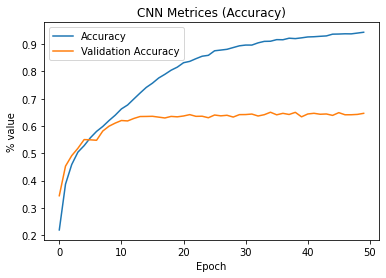

In [18]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Metrices (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

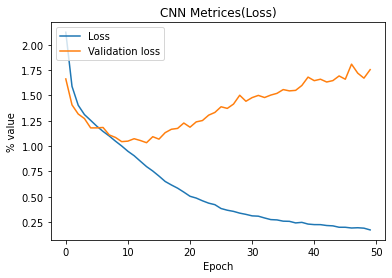

In [19]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('CNN Metrices(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()



-----------------------------------------------------


## Data augmentation & Dropout

Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better. 
When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process.

Implemented data augmentation and dropout using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`, `tf.keras.layers.Dropout`.

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

A few augmented examples look like by applying data augmentation to the same image several times:

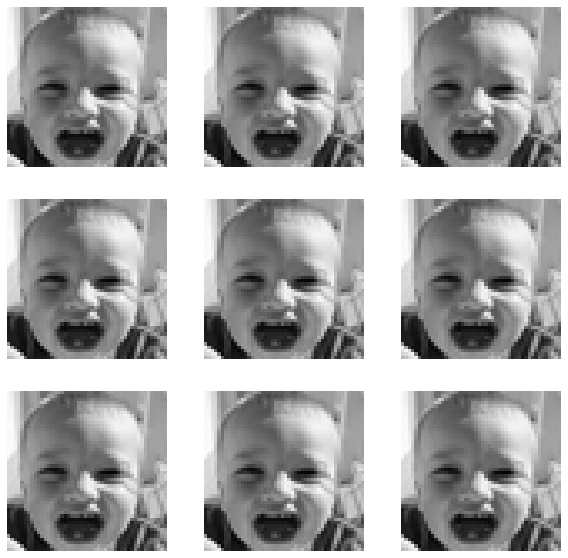

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Implemented CNN is credited SONYD4D's post from Kaggle.com: https://www.kaggle.com/code/sonyd4d/cnn-for-emotion-detection



In [22]:
num_classes = len(class_names)

model = tf.keras.Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(1./255))
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))


model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))


model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))


model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(num_classes))

## Compile and train the model

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.005)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 48, 48, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 activation_11 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                      

In [25]:
epochs = 150
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/150
898/898 [==============================] - 16s 15ms/step - loss: 2.0451 - accuracy: 0.2170 - val_loss: 1.7557 - val_accuracy: 0.2665
Epoch 2/150
898/898 [==============================] - 13s 15ms/step - loss: 1.7718 - accuracy: 0.2654 - val_loss: 1.7046 - val_accuracy: 0.2855
Epoch 3/150
898/898 [==============================] - 13s 15ms/step - loss: 1.6805 - accuracy: 0.3188 - val_loss: 1.5496 - val_accuracy: 0.3828
Epoch 4/150
898/898 [==============================] - 13s 15ms/step - loss: 1.5503 - accuracy: 0.3955 - val_loss: 1.4575 - val_accuracy: 0.4430
Epoch 5/150
898/898 [==============================] - 13s 15ms/step - loss: 1.4635 - accuracy: 0.4366 - val_loss: 1.3414 - val_accuracy: 0.4756
Epoch 6/150
898/898 [==============================] - 13s 15ms/step - loss: 1.4048 - accuracy: 0.4634 - val_loss: 1.2964 - val_accuracy: 0.5047
Epoch 7/150
898/898 [==============================] - 13s 15ms/step - loss: 1.3618 - accuracy: 0.4816 - val_loss: 1.2407 - val_ac

## Visualize training results

After applying data augmentation and dropout, here is a visual of how our test and training data did:

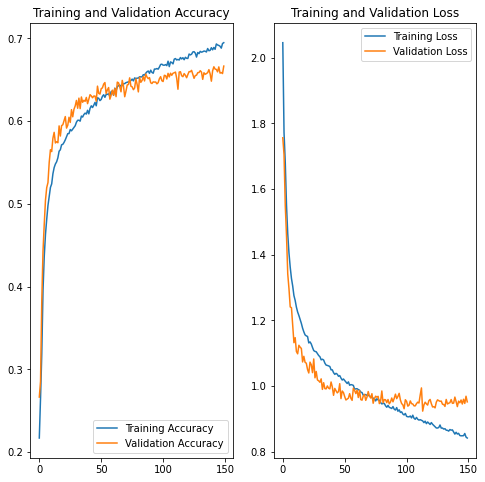

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Another implementation

The following is another implementation from Shurui Wang on Kaggle.com. The following is a link to the source code: https://www.kaggle.com/code/jadenwsr/emotion-detection-with-inceptionv3.

Wang uses inceptionV3 to pre-train the data to recognize emotion in facial expression. This implementation did slightly better than the above implementation.

Following hyper parameters are specific to this implementation of an InceptioV3 CNN. 

In [27]:
batch_size = 64 #?
img_height = 139
img_width = 139
num_classes = 7
EARLY_STOPPING_CRITERIA=3
EPOCHS = 39
FINE_TUNING_EPOCHS = 20
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

# Data Loading and Preproccessing Data 

In [28]:
preprocess_fun = tf.keras.applications.inception_v3.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = data_dir_train,
                                                    target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 125
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = data_dir_train,
                                                         target_size = (img_height ,img_width),
                                                         batch_size = batch_size,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 125
                                                        )

test_generator = test_datagen.flow_from_directory(directory = data_dir_test,
                                                   target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 125
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Splitting data into a training and validation dataset 

In [29]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.


In [30]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7178 files belonging to 7 classes.


# Configure the dataset for performance

As mentioned earlier, the following two important methods are used when loading data so you can yield data from disk without having I/O blocking.

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data

Again, as mentioned earlier, we standarize the data to be in the [0,1] range by using `tf.keras.layers.Rescaling`:

In [32]:
normalization_layer = layers.Rescaling(1./255)

Applying layer to the dataset by calling `Dataset.map`:

In [33]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0680773 1.0


# InceptionV3 Transfer Learning

In [34]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.InceptionV3(input_shape=(img_height,img_width, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(num_classes, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(img_height ,img_width,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [35]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 139, 139, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 classification (Dense)      (None, 7)                 7175      
                                                                 
Total params: 23,908,135
Trainable params: 2,105,351
Non-trainable params: 21,802,784
_________________________________________

# Training and Fine-Tuning

Training model with freezed layers of InceptionV3.

In [36]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/39
359/359 [==============================] - 142s 370ms/step - loss: 1.3331 - accuracy: 0.4944 - val_loss: 1.7526 - val_accuracy: 0.3174
Epoch 2/39
359/359 [==============================] - 123s 343ms/step - loss: 1.0312 - accuracy: 0.6130 - val_loss: 1.2427 - val_accuracy: 0.5424
Epoch 3/39
359/359 [==============================] - 123s 343ms/step - loss: 0.9108 - accuracy: 0.6564 - val_loss: 1.4273 - val_accuracy: 0.4652
Epoch 4/39
359/359 [==============================] - 123s 343ms/step - loss: 0.8272 - accuracy: 0.6956 - val_loss: 1.2369 - val_accuracy: 0.5529
Epoch 5/39
359/359 [==============================] - 123s 343ms/step - loss: 0.7576 - accuracy: 0.7196 - val_loss: 1.8077 - val_accuracy: 0.2496
Epoch 6/39
359/359 [==============================] - 123s 343ms/step - loss: 0.7023 - accuracy: 0.7375 - val_loss: 1.2740 - val_accuracy: 0.5377
Epoch 7/39
359/359 [==============================] - 124s 344ms/step - loss: 0.6372 - accuracy: 0.7632 - val_loss: 1.3008 -

# Fine Tuning

In [37]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

Epoch 1/20
359/359 [==============================] - 129s 345ms/step - loss: 0.7104 - accuracy: 0.7399 - val_loss: 0.9081 - val_accuracy: 0.6685
Epoch 2/20
359/359 [==============================] - 123s 344ms/step - loss: 0.6757 - accuracy: 0.7516 - val_loss: 0.9010 - val_accuracy: 0.6697
Epoch 3/20
359/359 [==============================] - 123s 343ms/step - loss: 0.6586 - accuracy: 0.7586 - val_loss: 0.8961 - val_accuracy: 0.6748
Epoch 4/20
359/359 [==============================] - 123s 342ms/step - loss: 0.6368 - accuracy: 0.7669 - val_loss: 0.8953 - val_accuracy: 0.6774
Epoch 5/20
359/359 [==============================] - 123s 343ms/step - loss: 0.6294 - accuracy: 0.7676 - val_loss: 0.8953 - val_accuracy: 0.6814
Epoch 6/20
359/359 [==============================] - 124s 345ms/step - loss: 0.6207 - accuracy: 0.7705 - val_loss: 0.8964 - val_accuracy: 0.6795
Epoch 7/20
359/359 [==============================] - 124s 344ms/step - loss: 0.6100 - accuracy: 0.7779 - val_loss: 0.8954 -

# Visualizing results

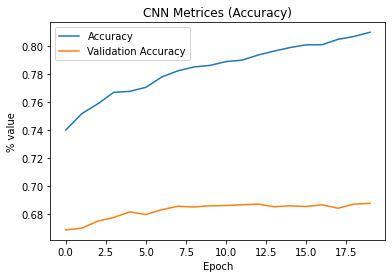

In [42]:
plt.plot(history_.history['accuracy'], label='Accuracy')
plt.plot(history_.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Metrices (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

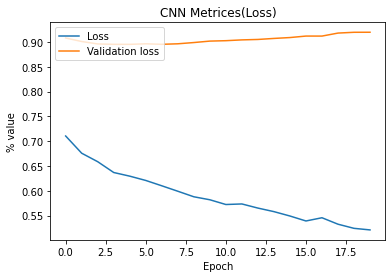

In [41]:
plt.plot(history_.history['loss'], label='Loss')
plt.plot(history_.history['val_loss'], label='Validation loss')
plt.title('CNN Metrices(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [43]:
neutral_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg"
neutral_path = tf.keras.utils.get_file('grace_hopper', origin=neutral_url)

img = tf.keras.utils.load_img(
    neutral_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

73728/61306 [====================================] - 0s 0us/step
This image most likely belongs to neutral with a 31.18 percent confidence.
